In [1]:
import umap
from sklearn.datasets import load_digits
import os
import glob
import numpy as np
import nibabel as nii
import math
import operator
#import patch_extraction
from scipy.ndimage.interpolation import zoom
from keras.models import load_model
from scipy import ndimage
import scipy.io as sio
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [39]:
	path=os.getcwd()

	# read data
	os.chdir('lib/Training')

FileNotFoundError: [Errno 2] No such file or directory: 'lib/Training'

In [40]:
listaT1 = sorted(glob.glob("n_*t1*.nii"))
listaFLAIR = sorted(glob.glob("n_*flair*.nii"))
listaLAB = sorted(glob.glob("wmhlesion*.nii*"))
listaMASK = sorted(glob.glob("mask*.nii"))
numfiles=len(listaT1)
subsmapling=32
epsilon=0.0001

In [28]:

# segment
for i in range(0,numfiles):
    #print(" ")
    #print("Images")
    #print(str(i+1))
    #		print(listaT1[i])
    #		print(listaFLAIR[i])
    #		print(listaMASK[i])
    #		print(listaLAB[i])
    try:
        
        T1_img = nii.load(listaT1[i])
        T1=T1_img.get_data()
        T1=T1.astype('float32')
        FLAIR_img = nii.load(listaFLAIR[i])
        FLAIR=FLAIR_img.get_data()
        FLAIR=FLAIR.astype('float32')
        #		LAB_img = nii.load(listaLAB[i])
        #		LAB=LAB_img.get_data()
        #		LAB=LAB.astype('int')
        
        MASK_img = nii.load(listaMASK[i])
        MASK = MASK_img.get_data()
        MASK=MASK.astype('int')
        
        ind=np.where(MASK>0)
        indbg=np.where(MASK==0)
        T1[indbg] = 0
        m1=np.mean(T1[ind])
        s1=np.std(T1[ind])+epsilon
        T1=(T1-m1)/s1

        FLAIR[indbg] = 0
        m1=np.mean(FLAIR[ind])
        s1=np.std(FLAIR[ind])+epsilon
        
        FLAIR=(FLAIR-m1)/s1
        T1= T1[::subsmapling,::subsmapling,::subsmapling]
        FLAIR= FLAIR[::subsmapling,::subsmapling,::subsmapling]
        
        FLAIR=FLAIR.reshape((1,FLAIR.shape[0],FLAIR.shape[1],FLAIR.shape[2],1))
        T1=T1.reshape((1,T1.shape[0],T1.shape[1],T1.shape[2],1))
        T1andFLAIR=np.concatenate((T1,FLAIR),axis=4)
        T1andFLAIR=T1andFLAIR.reshape((1,-1))
        if(i==0):
            T1andFLAIRlist=T1andFLAIR

        else:
            T1andFLAIRlist=np.concatenate((T1andFLAIRlist,T1andFLAIR),axis=0)
    except:
        print('problem sample n°: '+str(i))
        continue

problem sample n°: 5462
problem sample n°: 5463


In [29]:
np.save('hakswalhek.npy',T1andFLAIRlist)

In [3]:
T1andFLAIRlist=np.load('hakswalhek.npy')

In [32]:
T1andFLAIRlist[np.where(np.isnan(T1andFLAIRlist))]=0 #nan_to_num

In [4]:
for i in range(T1andFLAIRlist.shape[0]):
    if(not np.isnan(T1andFLAIRlist[i,:]).any()):
        if(i==0):
            T1andFLAIRlist_reduced=T1andFLAIRlist[i,:].reshape((1,-1))

        else:
            T1andFLAIRlist_reduced=np.concatenate((T1andFLAIRlist_reduced,T1andFLAIRlist[i,:].reshape((1,-1))),axis=0)
    else:
        print(i)
        

275
296
415
1153
1154
1240
1393
1404
4617


In [70]:
T1andFLAIRlist.shape

(5462, 504)

In [69]:
T1andFLAIRlist_reduced.shape

(5453, 504)

In [35]:
T1andFLAIRlist

array([[-6.036282 , -3.778098 , -6.036282 , ..., -3.778098 , -6.036282 ,
        -3.778098 ],
       [-4.5647774, -4.0140057, -4.5647774, ..., -4.0140057, -4.5647774,
        -4.0140057],
       [-6.4150596, -3.4174013, -6.4150596, ..., -3.4174013, -6.4150596,
        -3.4174013],
       ...,
       [-4.7353387, -4.026152 , -4.7353387, ..., -4.026152 , -4.7353387,
        -4.026152 ],
       [-4.7332573, -3.618836 , -4.7332573, ..., -3.618836 , -4.7332573,
        -3.618836 ],
       [-5.003375 , -2.363167 , -5.003375 , ..., -2.363167 , -5.003375 ,
        -2.363167 ]], dtype=float32)

In [25]:
#T1andFLAIRlist[np.where(np.isnan(T1andFLAIRlist))[0][51],np.where(np.isnan(T1andFLAIRlist))[1][60]]


nan

<function matplotlib.pyplot.show(*args, **kw)>

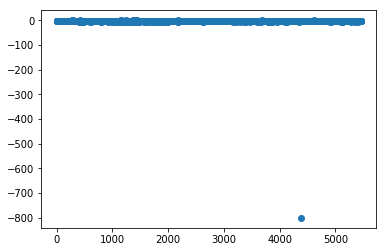

In [36]:
plt.scatter(np.arange(T1andFLAIRlist.shape[0]), T1andFLAIRlist[:, 1])
plt.show

In [5]:
import time

start = time.time()
reducer = umap.UMAP(min_dist=0,n_neighbors=500).fit(T1andFLAIRlist_reduced)
end = time.time()
print(end - start)


58.4820659160614


In [47]:
T1andFLAIRlist.shape

(5462, 504)

In [49]:
reducer.embedding_.shape

(5462, 2)

<function matplotlib.pyplot.show(*args, **kw)>

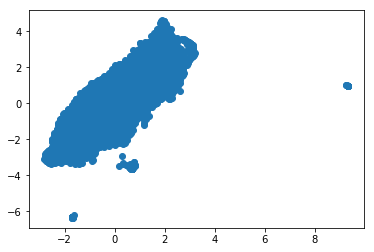

In [6]:
plt.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1])
plt.show

In [30]:
import sklearn.cluster as cluster

In [69]:
kmeans_labels = cluster.KMeans(n_clusters=25).fit_predict(reducer.embedding_)

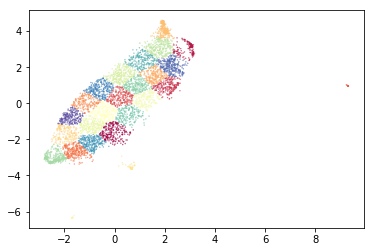

In [70]:
plt.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral')

In [22]:
#np.where(kmeans_labels_==1)[0]
listT=np.array(listaT1)

In [24]:
cluster_t1=listT[np.where(kmeans_labels_==1)[0]]


In [41]:
listaLAB

['wmhlesion_n_mfmni_fjob100427flair_check.nii',
 'wmhlesion_n_mfmni_fjob100428flair_check.nii',
 'wmhlesion_n_mfmni_fjob100429flair_check.nii',
 'wmhlesion_n_mfmni_fjob100430flair_check.nii',
 'wmhlesion_n_mfmni_fjob100431flair_check.nii',
 'wmhlesion_n_mfmni_fjob100432flair_check.nii',
 'wmhlesion_n_mfmni_fjob100433flair_check.nii',
 'wmhlesion_n_mfmni_fjob100434flair_check.nii',
 'wmhlesion_n_mfmni_fjob100435flair_check.nii',
 'wmhlesion_n_mfmni_fjob100436flair_check.nii',
 'wmhlesion_n_mfmni_fjob100590flair_check.nii',
 'wmhlesion_n_mfmni_fjob100775flair_check.nii',
 'wmhlesion_n_mfmni_fjob100778flair_check.nii',
 'wmhlesion_n_mfmni_fjob100779flair_check.nii',
 'wmhlesion_n_mfmni_fjob100780flair_check.nii',
 'wmhlesion_n_mfmni_fjob100940flair_check.nii',
 'wmhlesion_n_mfmni_fjob100982flair_check.nii',
 'wmhlesion_n_mfmni_fjob101275flair_check.nii',
 'wmhlesion_n_mfmni_fjob101336flair_check.nii',
 'wmhlesion_n_mfmni_fjob101374flair_check.nii',
 'wmhlesion_n_mfmni_fjob101416flair_chec

In [71]:
out={}


for i in range(25):
    
    cluster_t1=np.array(listaT1)[np.where(kmeans_labels==i)]
    cluster_flair=np.array(listaFLAIR)[np.where(kmeans_labels==i)]
    cluster_listaMASK=np.array(listaMASK)[np.where(kmeans_labels==i)]
    cluster_listaLAB=np.array(listaLAB)[np.where(kmeans_labels==i)]
    out["cluster_t1_"+str(i)]=cluster_t1
    out["cluster_flair_"+str(i)]=cluster_flair
    out["cluster_listaMASK_"+str(i)]=cluster_listaMASK
    out["cluster_listaLAB_"+str(i)]=cluster_listaLAB
    
    

In [73]:
for i in range(25):
    print(out["cluster_t1_"+str(i)].shape[0])

255
179
236
239
34
293
197
233
291
203
76
34
236
181
206
260
306
290
232
183
226
270
257
297
239


In [75]:
import random
out_reduced={}
cluster_t1_reduced=[]
cluster_flair_reduced=[]
cluster_listaMASK_reduced=[]
cluster_listaLAB_reduced=[]

for i in range(25):
    cluster_t1=out["cluster_t1_"+str(i)]
    cluster_flair=out["cluster_flair_"+str(i)]
    cluster_listaMASK=out["cluster_listaMASK_"+str(i)]
    cluster_listaLAB=out["cluster_listaLAB_"+str(i)]

    for j in range(20):
        rnd_int=random.randint(0,len(cluster_t1))
        cluster_t1_reduced.append(cluster_t1[j])
        cluster_flair_reduced.append(cluster_flair[j])
        cluster_listaMASK_reduced.append(cluster_listaMASK[j])
        cluster_listaLAB_reduced.append(cluster_listaLAB[j])

out_reduced['cluster_t1_reduced']=cluster_t1_reduced
out_reduced['cluster_flair_reduced']=cluster_flair_reduced
out_reduced['cluster_listaMASK_reduced']=cluster_listaMASK_reduced
out_reduced['cluster_listaLAB_reduced']=cluster_listaLAB_reduced

In [78]:
len(out_reduced['cluster_t1_reduced'])

500

In [81]:
!mkdir reduced


In [83]:
for i in out_reduced['cluster_t1_reduced']:
    os.system("cp "+"'"+i+"' "+"reduced/")

In [84]:
for i in out_reduced['cluster_flair_reduced']:
    os.system("cp "+"'"+i+"' "+"reduced/")
for i in out_reduced['cluster_listaMASK_reduced']:
    os.system("cp "+"'"+i+"' "+"reduced/")
for i in out_reduced['cluster_listaLAB_reduced']:
    os.system("cp "+"'"+i+"' "+"reduced/")

In [79]:
np.save("reduced_volbrain.npy",out_reduced)

In [74]:
np.save("by_cluster_25.npy",out)

In [74]:
np.where(reducer.embedding_[:, 0]>7.5)

(array([1333, 1334, 1335, 1336, 1338, 1339, 1340, 1343, 3211, 3212, 3213,
        3215, 3261, 3262, 3263, 3265, 3620, 3680, 3681, 3682, 3683, 3684,
        3685, 3686, 3687, 3689, 4125, 4126, 4175, 4176, 4177, 4178, 4179,
        4180, 4181, 4182, 4183, 4185]),)

In [52]:
#T1andFLAIRlist[1341]

In [75]:
np.where(reducer.embedding_[:, 1]<-6)

(array([ 965, 1049, 3106, 3109, 3111, 3112, 3113, 3114, 3115, 3116, 3117,
        3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128,
        3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139,
        3140, 3141]),)

In [51]:
#T1andFLAIRlist[3141]

In [86]:
np.where(np.logical_and(reducer.embedding_[:, 0]<-1, reducer.embedding_[:, 1]<-2))

(array([1110, 3106, 3109, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118,
        3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129,
        3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140,
        3141]),)

In [91]:
listaT1[1240]

'n_mfmni_fjob133036t1_check.nii'

In [64]:
T1andFLAIRlist[2610]

array([-2.6922352 , -1.6664052 , -2.6922352 , -1.6664052 , -2.6922352 ,
       -1.6664052 , -2.6922352 , -1.6664052 , -2.6922352 , -1.6664052 ,
       -2.6922352 , -1.6664052 , -2.6922352 , -1.6664052 , -2.6922352 ,
       -1.6664052 , -2.6922352 , -1.6664052 , -2.6922352 , -1.6664052 ,
       -2.6922352 , -1.6664052 , -2.6922352 , -1.6664052 , -2.6922352 ,
       -1.6664052 , -2.6922352 , -1.6664052 , -2.6922352 , -1.6664052 ,
       -2.6922352 , -1.6664052 , -2.6922352 , -1.6664052 , -2.6922352 ,
       -1.6664052 , -2.6922352 , -1.6664052 , -2.6922352 , -1.6664052 ,
       -2.6922352 , -1.6664052 , -2.6922352 , -1.6664052 , -2.6922352 ,
       -1.6664052 , -2.6922352 , -1.6664052 , -2.6922352 , -1.6664052 ,
       -2.6922352 , -1.6664052 , -2.6922352 , -1.6664052 , -2.6922352 ,
       -1.6664052 , -2.6922352 , -1.6664052 , -2.6922352 , -1.6664052 ,
       -2.6922352 , -1.6664052 , -2.6922352 , -1.6664052 , -2.6922352 ,
       -1.6664052 , -2.6922352 , -1.6664052 , -2.6922352 , -1.66